In [9]:
!pip install networkx scipy
!pip install plotly
!pip install pyvis
!pip install scikit-learn scipy seaborn
!pip install -U kaleido
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install scikit-bio
!pip install qiime2
!pip install qiime2-plugin-diversity
!pip install statannotations scikit-bio


ERROR: Could not find a version that satisfies the requirement qiime2 (from versions: none)
ERROR: No matching distribution found for qiime2
ERROR: Could not find a version that satisfies the requirement qiime2-plugin-diversity (from versions: none)
ERROR: No matching distribution found for qiime2-plugin-diversity


Setup, Style & Colors

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa
from statannotations.Annotator import Annotator
import os

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.4)

# Define Colors (Teal, Yellow, Red)
MY_PALETTE = {
    "Control": "#e7b9a0",                  # NC
    "Atopic_dermatitis_non_lesion": "#a7d3a4", # AD-NL
    "Atopic_dermatitis_lesion": "#92a4cf"   # AD-L
}

# Define Group Order & Labels
ORDER = ["Control", "Atopic_dermatitis_non_lesion", "Atopic_dermatitis_lesion"]
SHORT_LABELS = ["NC", "AD-NL", "AD-L"]

# Paths
INPUT_FILE = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/Final_Table_Taxonomy_Function_gtdb.tsv"
OUTPUT_DIR = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/figures/gtdb_quality/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete. Output directory created.")

Setup complete. Output directory created.


Load Data & Calculate Alpha Diversity

In [11]:
df = pd.read_csv(INPUT_FILE, sep='\t')

# Create readable labels (Genus + ID)
df['Label'] = df.apply(lambda x: x['Species'] if pd.notna(x['Species']) and len(str(x['Species'])) > 3 else f"{x['Genus']} ({x['mag_id']})", axis=1)

# Pivot Table: Rows=Samples, Cols=Bacteria
matrix = df.pivot_table(index='Sample', columns='Label', values='Abundance', fill_value=0)

# Map Samples to Groups
sample_to_group = df.drop_duplicates('Sample').set_index('Sample')['Group'].to_dict()
groups = matrix.index.map(sample_to_group)

# --- CALCULATE ALPHA DIVERSITY ---
def calc_shannon(row):
    """Calculates Shannon Entropy"""
    total = row.sum()
    if total == 0: return 0
    p = row / total
    p = p[p > 0]
    return -np.sum(p * np.log(p))

# Create Alpha DataFrame
alpha_df = pd.DataFrame(index=matrix.index)
alpha_df['Shannon'] = matrix.apply(calc_shannon, axis=1)
alpha_df['Richness'] = (matrix > 0).sum(axis=1) # Count observed species
alpha_df['Group'] = groups

print("Data loaded and Alpha Diversity calculated.")

def remove_outliers_iqr(df, column):
        
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    removed = len(df) - len(df_clean)
    if removed > 0:
        print(f"   -> [Filter IQR] Remove {removed} outliers '{column}'.")
    
    return df_clean

alpha_df_clean = alpha_df.copy()

print("-" * 40)
print(f"Initial Total: {len(alpha_df_clean)}")

alpha_df_clean = remove_outliers_iqr(alpha_df_clean, 'Shannon')

print(f"Final:   {len(alpha_df_clean)}")
print("-" * 40)

Data loaded and Alpha Diversity calculated.
----------------------------------------
Initial Total: 77
   -> [Filter IQR] Remove 8 outliers 'Shannon'.
Final:   69
----------------------------------------


Plot Alpha Diversity (Boxplots with Stats)

/tmp/ipykernel_7805/1499870806.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data, x='Group', y=metric, order=ORDER,
/tmp/ipykernel_7805/1499870806.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SHORT_LABELS)


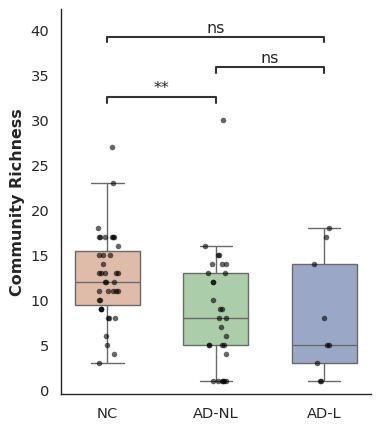

/tmp/ipykernel_7805/1499870806.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data, x='Group', y=metric, order=ORDER,
/tmp/ipykernel_7805/1499870806.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SHORT_LABELS)


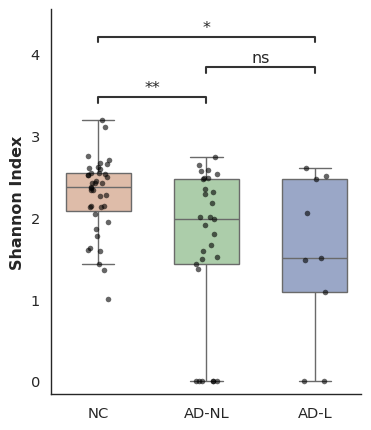

In [45]:
def plot_alpha_panel(data, metric, y_label, filename):
    plt.figure(figsize=(4, 5))
    
    ax = sns.boxplot(data=data, x='Group', y=metric, order=ORDER, 
                     palette=MY_PALETTE, width=0.6, fliersize=0)
    
    sns.stripplot(data=data, x='Group', y=metric, order=ORDER, 
                  color="black", size=4, alpha=0.6, ax=ax)
    
    pairs = [("Control", "Atopic_dermatitis_non_lesion"),
             ("Control", "Atopic_dermatitis_lesion"),
             ("Atopic_dermatitis_non_lesion", "Atopic_dermatitis_lesion")]
    
    annotator = Annotator(ax, pairs, data=data, x='Group', y=metric, order=ORDER)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=False)
    annotator.apply_and_annotate()
    
    ax.set_xlabel("")
    ax.set_ylabel(y_label, fontweight='bold')
    ax.set_xticklabels(SHORT_LABELS)
    
    sns.despine() 
    plt.savefig(os.path.join(OUTPUT_DIR, filename), bbox_inches='tight')
    plt.show()

plot_alpha_panel(alpha_df, 'Richness', 'Community Richness', 'Fig1a_Richness.svg')
plot_alpha_panel(alpha_df, 'Shannon', 'Shannon Index', 'Fig1b_Shannon.svg')

Plot Beta Diversity (PCoA)

/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(
/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:275: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.16309774740989819 whereas the largest positive one is 3.204951142214698.
  warn(
/tmp/ipykernel_7805/2125701237.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

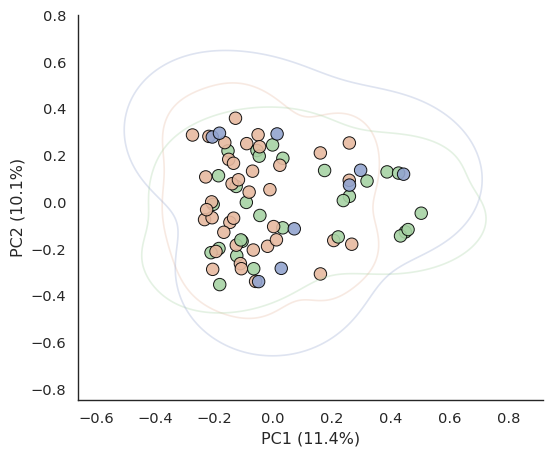

In [44]:
dist_matrix = pdist(matrix, metric='braycurtis')
pcoa_res = pcoa(squareform(dist_matrix))

pcoa_df = pcoa_res.samples[['PC1', 'PC2']]
pcoa_df['Group'] = groups
var_exp = pcoa_res.proportion_explained

plt.figure(figsize=(6, 5))

sns.scatterplot(data=pcoa_df, x='PC1', y='PC2', hue='Group', hue_order=ORDER,
                palette=MY_PALETTE, s=80, edgecolor='black', alpha=0.9, legend=False)

for g in ORDER:
    subset = pcoa_df[pcoa_df['Group'] == g]
    if len(subset) > 3:
        sns.kdeplot(x=subset['PC1'], y=subset['PC2'], 
                    levels=1, color=MY_PALETTE[g], alpha=0.3)

plt.xlabel(f"PC1 ({var_exp['PC1']:.1%})")
plt.ylabel(f"PC2 ({var_exp['PC2']:.1%})")

sns.despine()
plt.savefig(os.path.join(OUTPUT_DIR, 'Fig1c_PCoA.svg'), bbox_inches='tight')
plt.show()

Plot Abundance Bars (Top Species)

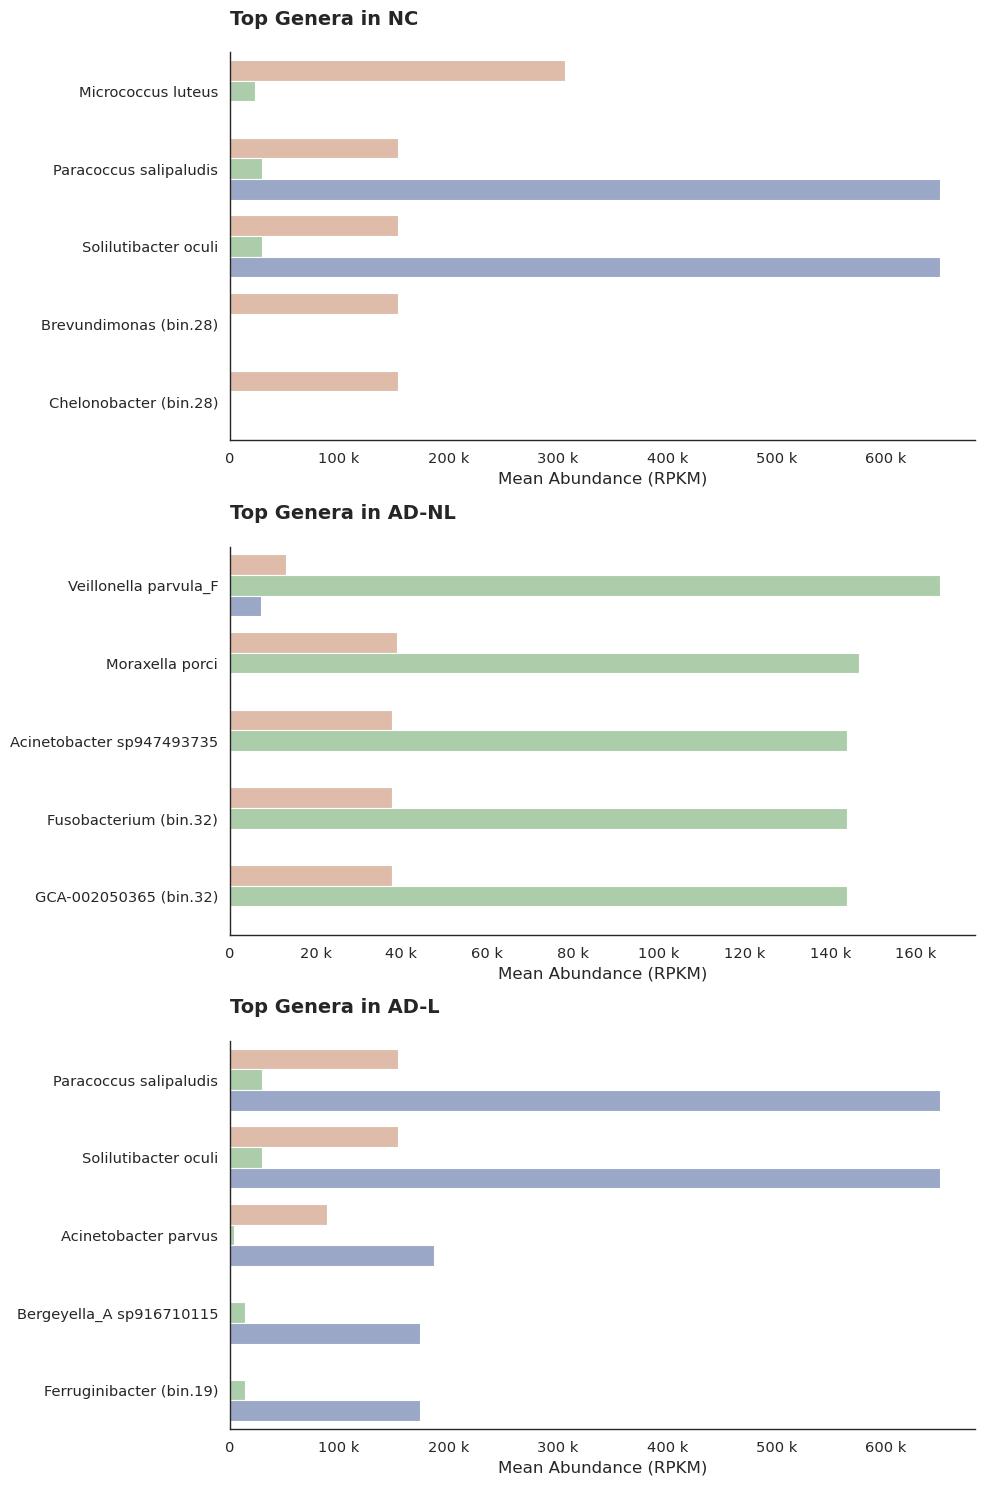

In [43]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns
import pandas as pd
import numpy as np
import os

if 'Label' not in df.columns:
    df['Label'] = df['Genus']

if isinstance(MY_PALETTE, dict):
    colors_list = list(MY_PALETTE.values())
    palette_final = dict(zip(ORDER, colors_list))
else:
    palette_final = MY_PALETTE

mean_abund = df.groupby(['Group', 'Label'])['Abundance'].mean().reset_index()

fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=False)

for i, group in enumerate(ORDER):
    ax = axes[i]
    
    top_5_labels = mean_abund[mean_abund['Group'] == group] \
                   .nlargest(5, 'Abundance')['Label'].tolist()
    
    plot_data = mean_abund[mean_abund['Label'].isin(top_5_labels)]
    
    sns.barplot(data=plot_data, y='Label', x='Abundance', hue='Group', 
                palette=palette_final, 
                order=top_5_labels,
                hue_order=ORDER,       
                dodge=True,
                ax=ax)
    
    ax.xaxis.set_major_formatter(ticker.EngFormatter()) 
    ax.set_title(f"Top Genera in {SHORT_LABELS[i]}", fontweight='bold', loc='left', fontsize=14, pad=20)
    ax.set_xlabel("Mean Abundance (RPKM)", fontsize=12)
    ax.set_ylabel("")
    
    if ax.get_legend():
        ax.legend_.remove()

legend_patches = []
colors_list = list(palette_final.values())

for i, label_text in enumerate(SHORT_LABELS):
    cor = colors_list[i] if i < len(colors_list) else 'grey'
    patch = mpatches.Patch(color=cor, label=label_text)
    legend_patches.append(patch)

plt.tight_layout() 
sns.despine()

save_path = os.path.join(OUTPUT_DIR, 'Fig1d_Genus_Abundance_Cleaned.svg')
plt.savefig(save_path, bbox_inches='tight')

plt.show()

network analysis

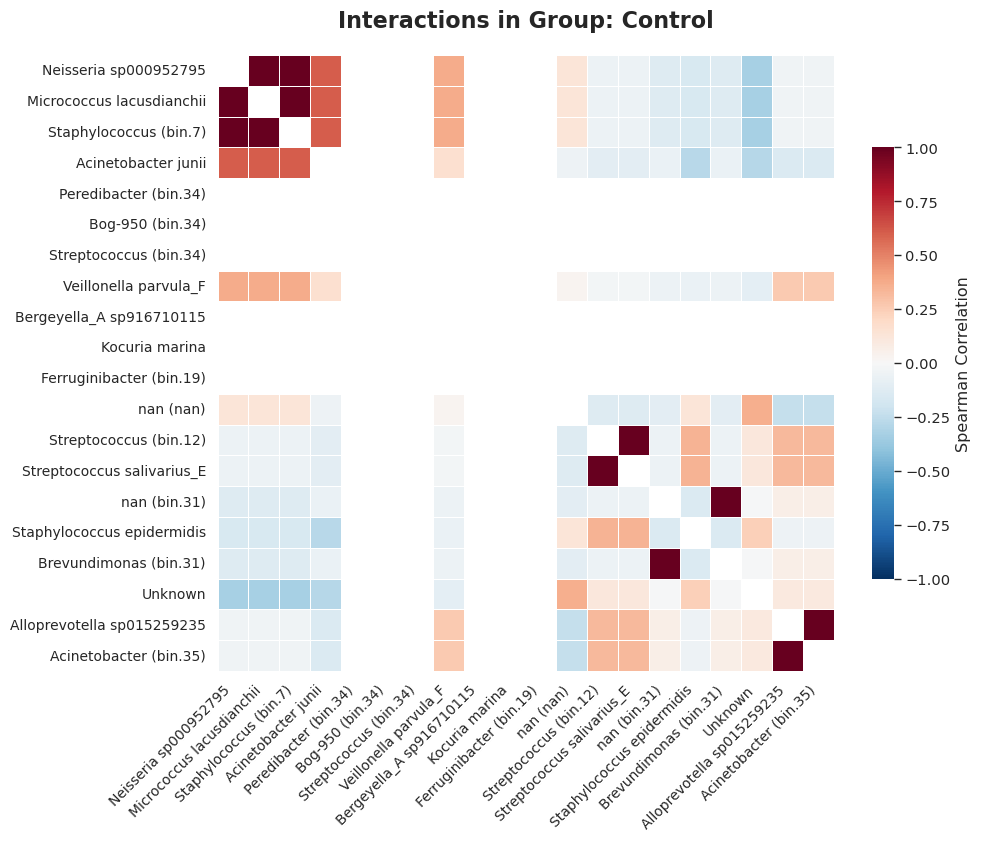

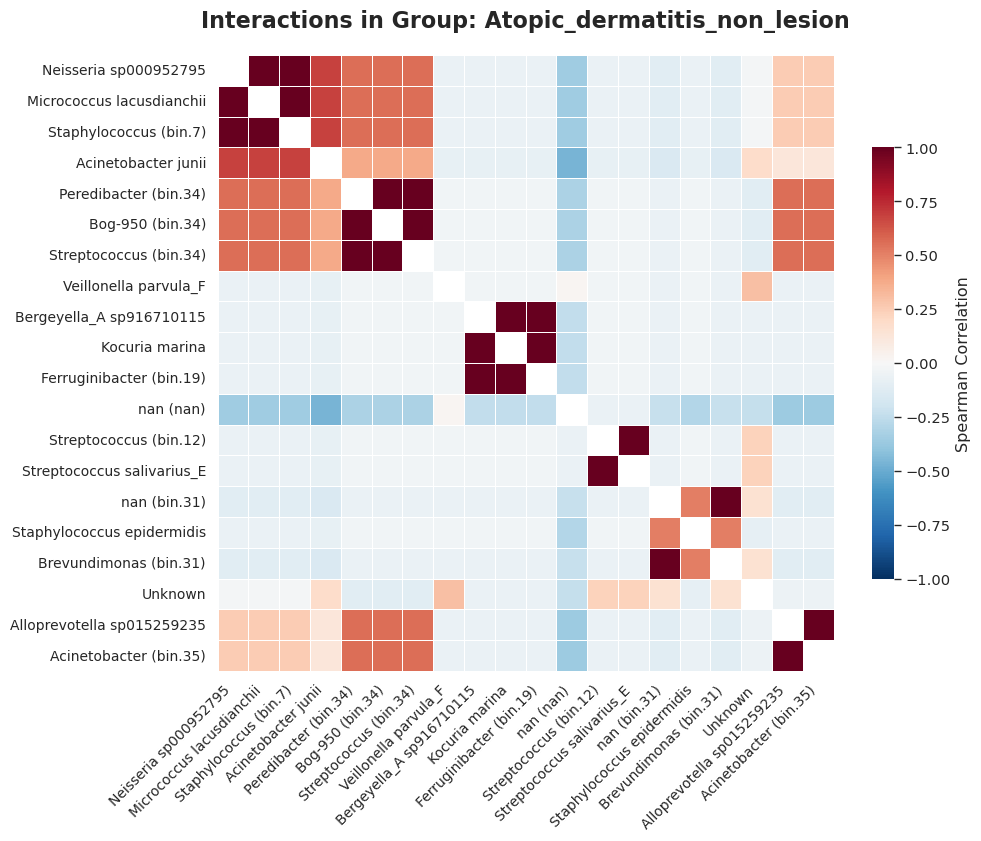

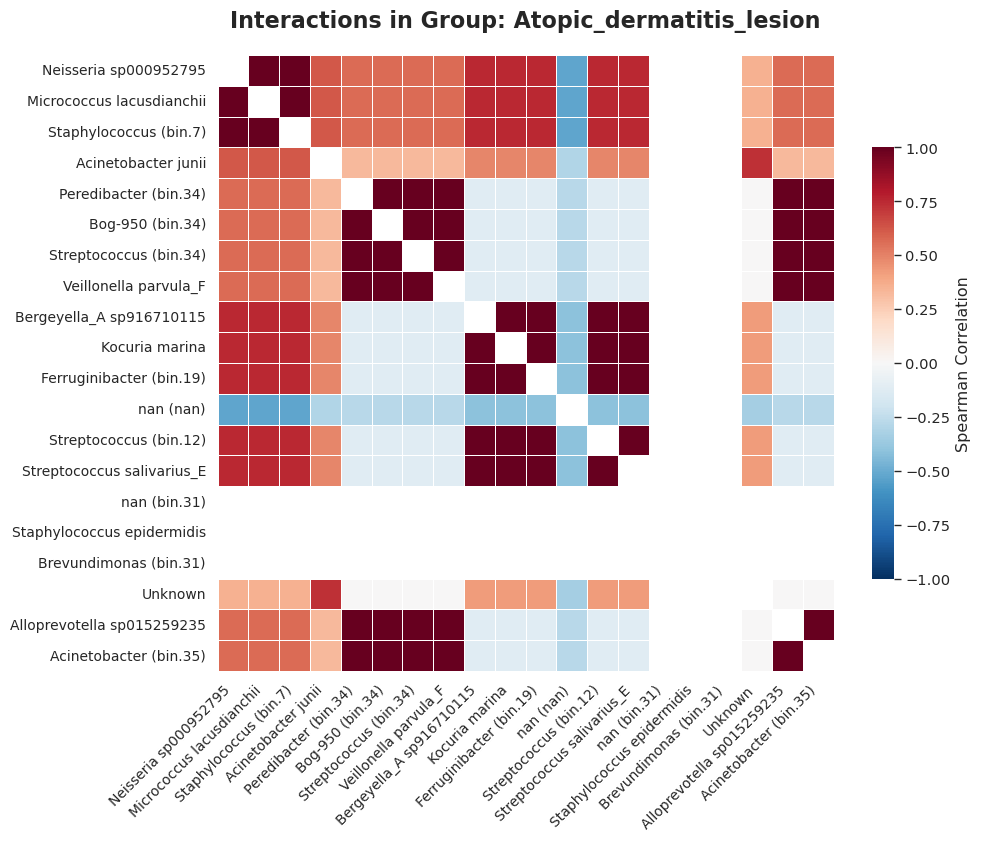

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

SEARCH_TERM = "Staphylococcus"
TOP_N_BACTERIA = 20
OUTPUT_DIR = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/figures/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

sns.set_theme(style="white", context="paper", font_scale=1.2)
plt.rcParams['font.family'] = 'sans-serif'

if 'Label' not in df.columns:
    if 'Genus' in df.columns: df['Label'] = df['Genus']
    elif 'Species' in df.columns: df['Label'] = df['Species']

matrix = df.pivot_table(index='Sample', columns='Label', values='Abundance', fill_value=0)

matches = [col for col in matrix.columns if SEARCH_TERM.lower() in str(col).lower()]
if not matches:
    raise ValueError(f"Error: Target '{SEARCH_TERM}' not found in data.")
TARGET = matches[0]

global_corr = matrix.corrwith(matrix[TARGET], method='spearman').abs()
top_neighbors = global_corr.sort_values(ascending=False).head(TOP_N_BACTERIA).index.tolist()

if 'ORDER' not in locals(): 
    ORDER = ['NC', 'AD-NL', 'AD-L'] 
    
sample_to_group = df.drop_duplicates('Sample').set_index('Sample')['Group'].to_dict()

for group in ORDER:
    samples_in_group = [s for s, g in sample_to_group.items() if g == group]
    valid_samples = [s for s in samples_in_group if s in matrix.index]
    
    if len(valid_samples) < 3:
        continue
        
    group_matrix = matrix.loc[valid_samples]
    group_corr = group_matrix.corr(method='spearman').loc[top_neighbors, top_neighbors]
    
    np.fill_diagonal(group_corr.values, np.nan)
    
    plt.figure(figsize=(10, 8))
    
    ax = sns.heatmap(group_corr,
                     cmap="RdBu_r",
                     center=0,
                     vmin=-1, vmax=1,
                     annot=False,
                     square=True,
                     linewidths=0.5,
                     linecolor='white',
                     cbar_kws={"shrink": .7, "label": "Spearman Correlation"})

    plt.title(f"Interactions in Group: {group}", fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.xlabel("")
    plt.ylabel("")

    filename = f"Heatmap_Group_{group}_{TARGET}.svg"
    save_path = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()

--- 1. Identifying VIP Bacteria & Target ---
✅ Target Identified: Staphylococcus (bin.7)
✅ Selected 13 dominant bacteria to check interactions.
--- 2. Calculating Interactions per Group ---


/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


✅ Saved to: /home/marcos/PRJEB59406/ORGANIZED_RESULTS/figures/Heatmap_Interaction_TopAbundant_Staphylococcus (bin.7).svg


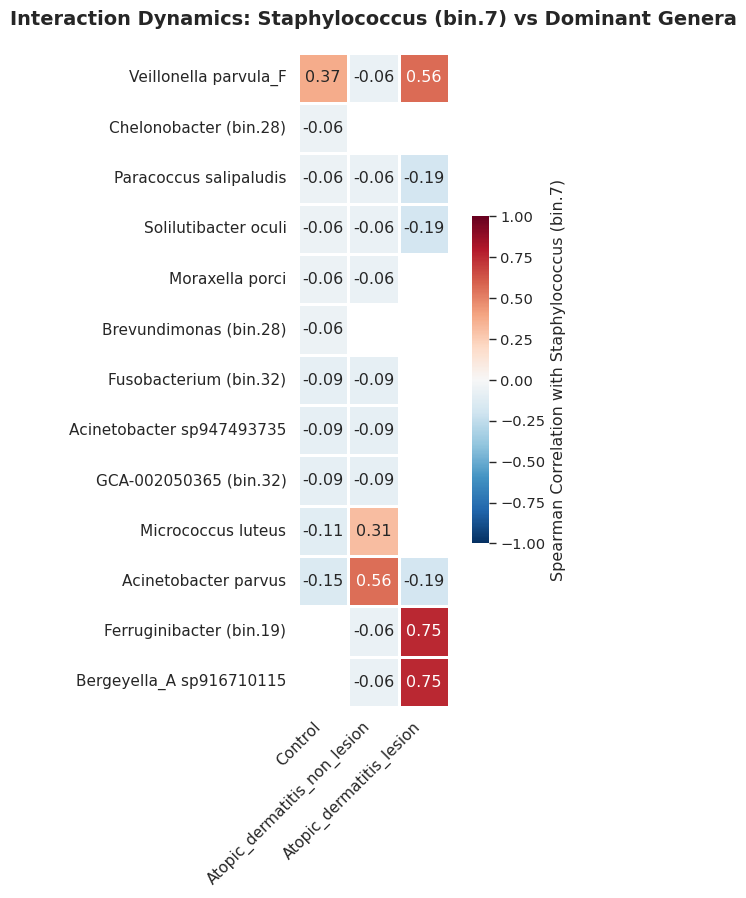

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

SEARCH_TERM = "Staphylococcus"
OUTPUT_DIR = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/figures/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

sns.set_theme(style="white", context="paper", font_scale=1.2)
plt.rcParams['font.family'] = 'sans-serif'

if 'ORDER' not in locals(): ORDER = ['NC', 'AD-NL', 'AD-L']

if 'Label' not in df.columns:
    if 'Genus' in df.columns: df['Label'] = df['Genus']
    elif 'Species' in df.columns: df['Label'] = df['Species']

print("--- 1. Identifying VIP Bacteria & Target ---")

temp_matrix = df.pivot_table(index='Sample', columns='Label', values='Abundance', fill_value=0)
matches = [col for col in temp_matrix.columns if SEARCH_TERM.lower() in str(col).lower()]

if not matches:
    raise ValueError(f"Target '{SEARCH_TERM}' not found in data.")
TARGET = matches[0]
print(f"✅ Target Identified: {TARGET}")

mean_abund = df.groupby(['Group', 'Label'])['Abundance'].mean().reset_index()

vip_bacteria = set()
for group in ORDER:
    top_5 = mean_abund[mean_abund['Group'] == group].nlargest(5, 'Abundance')['Label'].tolist()
    vip_bacteria.update(top_5)

if TARGET in vip_bacteria:
    vip_bacteria.remove(TARGET)

vip_list = list(vip_bacteria)
print(f"✅ Selected {len(vip_list)} dominant bacteria to check interactions.")

print("--- 2. Calculating Interactions per Group ---")

sample_to_group = df.drop_duplicates('Sample').set_index('Sample')['Group'].to_dict()

interaction_data = {}

matrix = temp_matrix # Reusing the pivot table created above

for group in ORDER:
    samples = [s for s, g in sample_to_group.items() if g == group]
    valid_samples = [s for s in samples if s in matrix.index]
    
    if len(valid_samples) < 3:
        print(f"Skipped {group}: Not enough samples.")
        continue

    group_matrix = matrix.loc[valid_samples]
    
    corr = group_matrix.corrwith(group_matrix[TARGET], method='spearman')
    
    interaction_data[group] = corr.loc[vip_list]

df_heatmap = pd.DataFrame(interaction_data)
df_heatmap = df_heatmap[ORDER]
df_heatmap = df_heatmap.sort_values(by=ORDER[0], ascending=False)
plt.figure(figsize=(6, len(vip_list)*0.5 + 2))
ax = sns.heatmap(df_heatmap,
                 cmap="RdBu_r",       # Red (Positive) <-> Blue (Negative)
                 center=0,
                 vmin=-1, vmax=1,     # Fixed scale -1 to 1
                 annot=True,          # Show correlation values
                 fmt=".2f",
                 square=True,
                 linewidths=1,        # White grid lines
                 linecolor='white',
                 cbar_kws={"shrink": .5, "label": f"Spearman Correlation with {TARGET}"})

plt.title(f"Interaction Dynamics: {TARGET} vs Dominant Genera", fontsize=14, fontweight='bold', pad=20)
plt.xlabel("") 
plt.ylabel("")

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)

filename = f"Heatmap_Interaction_TopAbundant_{TARGET}.svg"
save_path = os.path.join(OUTPUT_DIR, filename)
plt.savefig(save_path, bbox_inches='tight', dpi=300)
print(f"Saved to: {save_path}")

plt.show()